## Using GkNN as the Decoder

In [1]:
%config InlineBackend.figure_format = 'svg'

import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from my_models import Transformer1d
from my_utilities import MatReader,count_params,mytrain

seed = 0


os.environ["PYTHONHASHSEED"] = str(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.set_printoptions(precision=16)


### Data Loading

In [2]:
data_path = "data/burgers_data_R10.mat"
dataloader = MatReader(data_path)

L = 1
subrate = 2**3
gridsize = 2**13 // subrate
x_data = dataloader.read_field("a")[:, ::subrate].unsqueeze(-1)
y_data = dataloader.read_field("u")[:, ::subrate]
num_data = x_data.size(0)

grid = torch.linspace(0, L, gridsize + 1)[:-1].unsqueeze(-1)
x_data = torch.cat((x_data, grid.repeat([num_data, 1, 1])), dim=-1)

print("number of data:", num_data, "grid size now:", gridsize)

number of data: 2048 grid size now: 1024


### Generation of Arbitrary Grid and $\Delta x$

grid size selected: 256
index selected: [   0    2    5    8   14   18   27   30   31   34   37   40   45   54
   55   60   62   65   75   77   79   85   97  101  103  108  113  122
  141  142  144  145  150  154  158  175  190  193  196  200  202  204
  214  215  230  231  236  239  240  247  249  251  252  253  255  261
  264  266  267  270  272  278  279  283  294  295  298  299  308  311
  312  316  319  320  330  331  342  351  352  358  361  362  363  364
  366  367  378  380  384  386  395  399  402  403  406  408  409  412
  413  416  418  424  425  432  436  443  447  451  453  456  457  467
  474  477  479  481  482  484  485  491  492  493  496  500  501  503
  513  518  521  522  530  531  545  546  557  568  569  571  582  587
  588  590  596  604  605  608  609  612  619  625  627  631  646  648
  650  653  654  664  669  670  674  676  678  682  686  688  695  704
  711  712  721  722  729  732  733  738  740  742  743  751  752  757
  764  767  768  772  773  776  783  

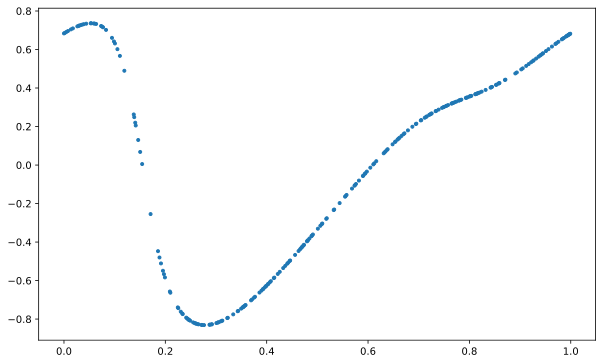

In [3]:
s = 2**8
np.random.seed(seed)
index_selected = np.random.choice(range(gridsize), s, replace=False)

index_selected.sort()
index_selected[0], index_selected[s - 1] = 0, gridsize - 1
grid = torch.tensor(index_selected) / gridsize


print("grid size selected:", s)
print("index selected:", index_selected)

delta_start = 1 / 2 * grid[1].unsqueeze(0)
delta_end = 1 / 2 * (1 - grid[-2]).unsqueeze(0)
delta_mid = 1 / 2 * (grid[2:] - grid[:-2])
delta_x = torch.cat((delta_start, delta_mid, delta_end))
print("the first ten delta x for example:",delta_x[0:10])


x_selected = x_data[:, index_selected, :]
y_selected = y_data[:, index_selected]

plt.figure(figsize=(10, 6))
plt.scatter(grid, y_selected[0, :], marker=".")


### Generation of Bases

torch.Size([256, 33]) torch.Size([256])
verify orthonormality: Int(base3^2 dx)=0.9999226927757263,Int(base3*base5 dx)=-0.0003674302715808153


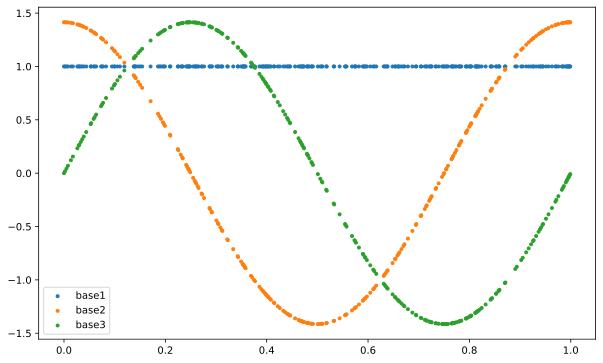

In [4]:
ntrain = 2**10
modes = 33
bases_types = ["Fourier", "Principal"]
bases_type = bases_types[0]

plt.figure(figsize=(10, 6))
if bases_type == "Fourier":
    fbases = np.zeros((s, modes))
    fbases[:, 0] = 1 / np.sqrt(L)
    for i in range(modes // 2):
        fbases[:, 2 * i + 1] = np.sqrt(2 / L) * np.cos(2 * np.pi * (i + 1) * grid / L)
        if 2 * i + 2 <= modes - 1:
            fbases[:, 2 * i + 2] = np.sqrt(2 / L) * np.sin(
                2 * np.pi * (i + 1) * grid / L
            )
    fbases = torch.from_numpy(fbases.astype(np.float32))
    bases = fbases
    print(bases.size(),delta_x.size())
    wbases = torch.einsum("sm,s->sm", fbases, delta_x)
elif bases_type == "Principal":
    pca_data = y_selected[:ntrain, :].T
    plt.scatter(grid, pca_data[:, 0], marker=".", label="u")
    U, S, VT = np.linalg.svd(pca_data)
    fbases = U[:, :modes] / np.sqrt(L / s)
    wfbases = L / s * fbases
    bases = torch.from_numpy(fbases.astype(np.float32))
    wbases = torch.from_numpy(wfbases.astype(np.float32))

for i in range(3):
    plt.scatter(grid, fbases[:, i], marker=".", label="base" + str(i + 1))
plt.legend()
print(f"verify orthonormality: Int(base3^2 dx)={sum(bases[:, 3] * wbases[:, 3]).item()},Int(base3*base5 dx)={sum(bases[:, 3] * wbases[:, 5]).item()}")

### Model Settings

In [5]:
attn_types=["Fourier","Galerkin"]
decoder_types=["Fourier","Galerkin","Linear"]
model = Transformer1d(
    width=96,
    width_ffn=192,
    delta_x=delta_x,
    num_encoders=0,
    num_heads=1,
    attention_type=attn_types[1],
    decoder_type=decoder_types[1],
    num_docoderlayers=4,
    modes=modes,
    bases=bases,
    wbases=wbases,
)
print("number of parameters:", count_params(model))

attention type: Galerkin
decoder type: Galerkin
number of parameters: 394561


### Training

In [6]:
Loss_train, Loss_test = mytrain(
    model=model,
    x=x_selected,
    y=y_selected,
    grid=grid,
    learning_rate=0.001,
    step_size=50,
    # milestones=[0,40,80,120,160],
    gamma=0.1,
    epochs=150,
    batch_size=8,
    ntrain=2**10,
    ntest=2**9,
    save_path="model1d.pth",
)

ntrain: 1024 ntest: 512
using l2 loss in training and testing
begin training
learning rate changed: 0.001
001 | time 1.39 | train 0.391478836420 | test 0.301998694427
002 | time 1.32 | train 0.282366763568 | test 0.214307484683
003 | time 1.30 | train 0.169529786217 | test 0.127916637459
004 | time 1.28 | train 0.101258259558 | test 0.073595490830
005 | time 1.30 | train 0.073978366185 | test 0.072870213829
006 | time 1.30 | train 0.056587420200 | test 0.045598183176
007 | time 1.30 | train 0.050819196709 | test 0.037202420674
008 | time 1.31 | train 0.039867658983 | test 0.038337803097
009 | time 1.29 | train 0.038593950696 | test 0.031585118559
010 | time 1.31 | train 0.034941232312 | test 0.037704537390
011 | time 1.29 | train 0.032994945796 | test 0.028935539653
012 | time 1.29 | train 0.034231404905 | test 0.029294203530
013 | time 1.27 | train 0.031570221880 | test 0.031625003321
014 | time 1.26 | train 0.031499845136 | test 0.023699173355
015 | time 1.27 | train 0.033419779691 |

In [ ]:
model.eval()